In [39]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})

In [41]:
# Custom functions and tools 

import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

In [4]:
%%time
# load lite version of Gaia DR3 for quick cone searches
gaia_lite = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", columns=['ra',
                                                                                         'dec', 
                                                                                     "parallax", 
                                                                                         "phot_g_mean_mag"])
#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates',
                                'teff_gspphot', 'teff_gspphot_upper', 'teff_gspphot_lower',
                                'logg_gspphot', 'logg_gspphot_lower', 'logg_gspphot_upper',
                                'mh_gspphot','mh_gspphot_lower', 'mh_gspphot_upper',
                                'distance_gspphot', 'distance_gspphot_lower','distance_gspphot_upper',
                                'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper', 'ag_gspphot', 
                                 'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
                                'Norder', 'Npix', 'Dir'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 56.8 s, sys: 6.46 s, total: 1min 3s
Wall time: 1min 4s


In [5]:
%%time
# load pre-saved FG sample
_sample_hips = lsdb.read_hipscat("/astro/users/atzanida/epyc/ssd/users/atzanida/tmp/data_files/fg_sample")

CPU times: user 2.39 s, sys: 118 ms, total: 2.51 s
Wall time: 2.49 s


In [966]:
ztf_sources

,index,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
npartitions=311037,,,,,,,,,,,,,,,,,,,,,,,
0,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13834987686537986048,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
# do not run
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")
# ran at 415

CPU times: user 943 ms, sys: 36.4 ms, total: 979 ms
Wall time: 983 ms


In [6]:
# do not run
%%time
_all_sky_object = _all_sky_object.compute()
# ran at 415

CPU times: user 1h 31min 4s, sys: 1h 32min 32s, total: 3h 3min 36s
Wall time: 20min 26s


In [7]:
# do not run
print (f"Number of unique sources: {len(_all_sky_object.index.unique())}")

Number of unique sources: 4833834


In [9]:
# do not run
%%time 
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _all_sky_object, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

CPU times: user 3min 5s, sys: 8.83 s, total: 3min 14s
Wall time: 3min 13s


In [6]:
%%time
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 1min 21s, sys: 2.44 s, total: 1min 23s
Wall time: 1min 23s


In [11]:
# lazy loading sources
_sources

,ra_gaia_,dec_gaia_,parallax_gaia_,parallax_over_error_gaia_,bp_rp_gaia_,solution_id_gaia_,source_id_gaia_,pmra_gaia_,pmra_error_gaia_,pmdec_gaia_,pmdec_error_gaia_,parallax_error_gaia_,phot_g_mean_mag_gaia_,l_gaia_,b_gaia_,non_single_star_gaia_,classprob_dsc_combmod_galaxy_gaia_,classprob_dsc_combmod_star_gaia_,in_qso_candidates_gaia_,teff_gspphot_gaia_,teff_gspphot_upper_gaia_,teff_gspphot_lower_gaia_,logg_gspphot_gaia_,logg_gspphot_lower_gaia_,logg_gspphot_upper_gaia_,mh_gspphot_gaia_,mh_gspphot_lower_gaia_,mh_gspphot_upper_gaia_,distance_gspphot_gaia_,distance_gspphot_lower_gaia_,distance_gspphot_upper_gaia_,azero_gspphot_gaia_,azero_gspphot_lower_gaia_,azero_gspphot_upper_gaia_,ag_gspphot_gaia_,ebpminrp_gspphot_gaia_,ebpminrp_gspphot_lower_gaia_,ebpminrp_gspphot_upper_gaia_,Norder_gaia_,Npix_gaia_,Dir_gaia_,ps1_objid_ztf_dr14_,ra_ztf_dr14_,dec_ztf_dr14_,ps1_gMeanPSFMag_ztf_dr14_,ps1_rMeanPSFMag_ztf_dr14_,ps1_iMeanPSFMag_ztf_dr14_,nobs_g_ztf_dr14_,nobs_r_ztf_dr14_,nobs_i_ztf_dr14_,mean_mag_g_ztf_dr14_,mean_mag_r_ztf_dr14_,mean_mag_i_ztf_dr14_,Norder_ztf_dr14_,Dir_ztf_dr14_,Npix_ztf_dr14_,_DIST_,Norder_,Dir_,Npix_,index_ztf_source,ps1_objid_ztf_source,ra_ztf_source,dec_ztf_source,ps1_gMeanPSFMag_ztf_source,ps1_rMeanPSFMag_ztf_source,ps1_iMeanPSFMag_ztf_source,nobs_g_ztf_source,nobs_r_ztf_source,nobs_i_ztf_source,mean_mag_g_ztf_source,mean_mag_r_ztf_source,mean_mag_i_ztf_source,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
npartitions=287241,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13833861786631143424,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [156]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# Initialize an Ensemble
ens = Ensemble(n_workers=48, threads_per_worker=1, memory_limit="24G")
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39622 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39622/status,
Dashboard: http://127.0.0.1:39622/status,Workers: 48
Total threads: 48,Total memory: 1.05 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37927,Workers: 48
Dashboard: http://127.0.0.1:39622/status,Total threads: 48
Started: Just now,Total memory: 1.05 TiB
Comm: tcp://127.0.0.1:35256,Total threads: 1
Dashboard: http://127.0.0.1:36056/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:39067,


In [157]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


## Testing Functionalities

In [44]:
%%time
# demo tool estimate the nearest neighbour given ra, dec
my_tools.estimate_gaiadr3_density_async(131.1, 22.3)

CPU times: user 931 ms, sys: 924 ms, total: 1.86 s
Wall time: 1.31 s


{'closest_bright_star_arcsec': 0.0075408123219372295,
 'closest_bright_star_mag': 16.448757,
 'closest_star_arcsec': 0.0075408123219372295,
 'closest_star_mag': 16.448757,
 'density_arcsec2': 6872.744168992514}

## Test Light Curve

In [178]:
%%time
# know dipper
lc = ens.source.loc[106670401437827072]
lc = lc.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 17.6 s, sys: 3.85 s, total: 21.5 s
Wall time: 20.5 s


In [185]:
lc

,ra_gaia_andy_fg_dwarfs,dec_gaia_andy_fg_dwarfs,parallax_gaia_andy_fg_dwarfs,parallax_over_error_gaia_andy_fg_dwarfs,bp_rp_gaia_andy_fg_dwarfs,solution_id_gaia_andy_fg_dwarfs,source_id_gaia_andy_fg_dwarfs,pmra_gaia_andy_fg_dwarfs,pmra_error_gaia_andy_fg_dwarfs,pmdec_gaia_andy_fg_dwarfs,...,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,0,558,15.415235,0.011039,58805.42942,53,r,7,0,1515
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,0,558,15.410956,0.011033,58805.42761,53,r,7,0,1515
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,0,558,15.408195,0.011030,58805.42445,53,r,7,0,1515
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,0,558,15.422739,0.011048,58805.42671,53,r,7,0,1515
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,0,558,15.403024,0.011024,58805.40729,53,r,7,0,1515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,-32768,558,16.407421,0.014260,59219.20916,53,g,7,0,1515
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,-32768,608,16.379829,0.016132,59219.20822,10,g,7,0,1515
106670401437827072,59.658357,22.446877,1.664129,47.882496,1.54774,1636148068921376768,53335183057362048,1.417529,0.044125,-4.240105,...,0,608,16.349361,0.016050,59215.22311,10,g,7,0,1515


In [183]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

<ErrorbarContainer object of 3 artists>

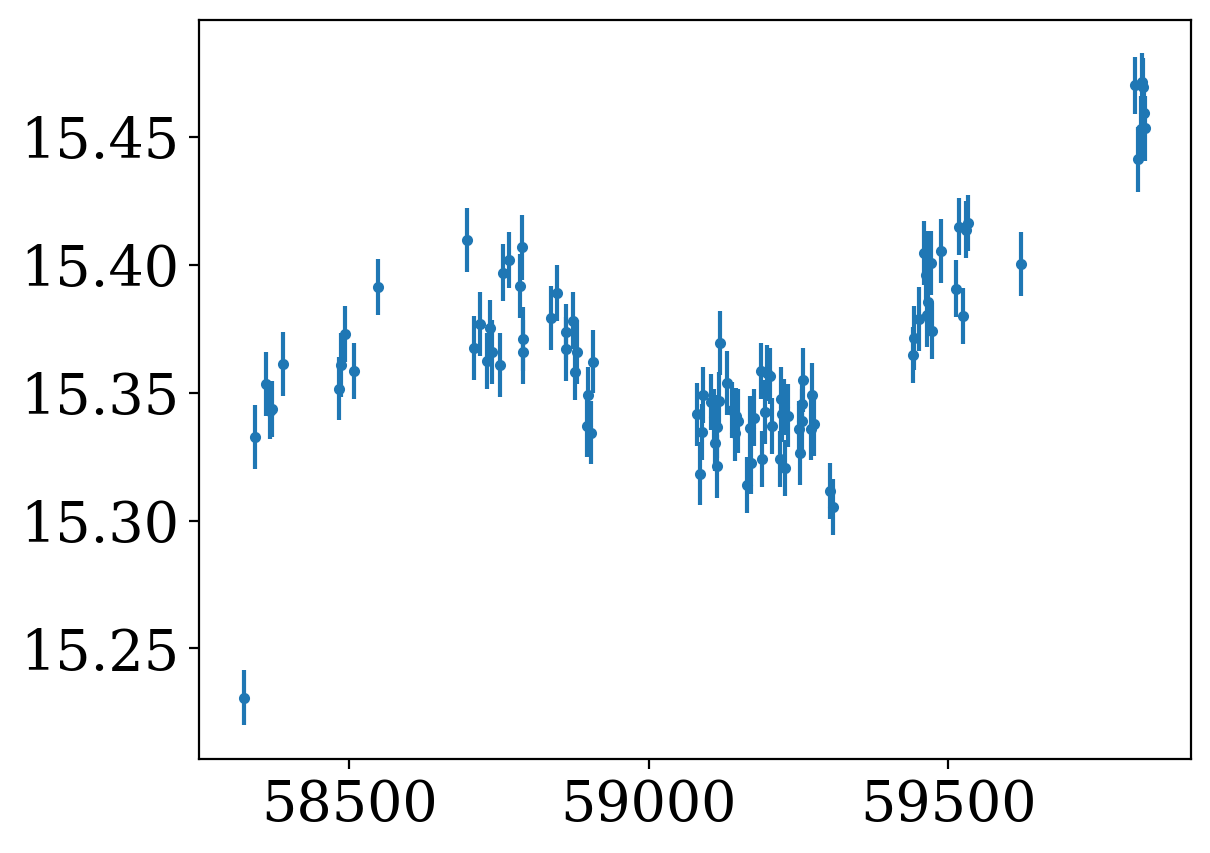

In [184]:
plt.errorbar(time, mag, magerr, fmt='.')

In [53]:
import astropy.stats as astro_stats
# Evaluate biweight location and scale
R, S = astro_stats.biweight.biweight_location(mag), astro_stats.biweight.biweight_scale(mag)

# Running deviation
running_deviation = dip_pipeline.deviation(mag, magerr, R, S)

## Time Series Calculations

In [164]:
column_names = ['Nphot',
    'biweight_scale',
    'frac_above_2_sigma',
    'Ndips',
    'rate',
    'chi2dof',
    'ADF_const',
    'ADF_const_trend',
    'ADF_pval_const',
    'ADF_pval_const_trend',
    'skew', 
    'kurtosis',
    'mad',
    'stetson_i',
    'stetson_j',
    'stetson_k',
    'invNeumann',
    'best_dip_power',
    'best_dip_time_loc',
    'best_dip_start',
    'best_dip_end',
    'best_dip_dt',
    'best_dip_ndet',
    'best_dip_score',
    'left_error',
    'right_error',
    'chi_square_gp',
    'gp_fun',
    'gp_status',
    'separation_btw_peaks',
    'closest_bright_star_arcsec',
    'closest_bright_star_mag',
    'closest_star_arcsec',
    'closest_star_mag',
    'density_arcsec2']

### Test `Evaluate` on a single light curve

In [ ]:
len(lc['mjd_ztf_source'].values)

In [149]:

print (evaluate(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'], lc['ra_ztf_source'].values[0], 
        lc['dec_ztf_source'].values[0]))

Nphot                        NaN
biweight_scale               NaN
frac_above_2_sigma           NaN
Ndips                        NaN
rate                         NaN
chi2dof                      NaN
ADF_const                    NaN
ADF_const_trend              NaN
ADF_pval_const               NaN
ADF_pval_const_trend         NaN
skew                         NaN
kurtosis                     NaN
mad                          NaN
stetson_i                    NaN
stetson_j                    NaN
stetson_k                    NaN
invNeumann                   NaN
best_dip_power               NaN
best_dip_time_loc            NaN
best_dip_start               NaN
best_dip_end                 NaN
best_dip_dt                  NaN
best_dip_ndet                NaN
best_dip_score               NaN
left_error                   NaN
right_error                  NaN
chi_square_gp                NaN
gp_fun                       NaN
gp_status                    NaN
separation_btw_peaks         NaN
closest_br

## Batch Calculation

In [159]:
# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=column_names, dtype=float)

In [160]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    evaluate,
    'mjd_ztf_source', 'mag_ztf_source', 
    'magerr_ztf_source', 'catflags_ztf_source',
    'band_ztf_source', 'ra_ztf_source', 
    'dec_ztf_source',
    meta=my_meta,
    use_map=True)

Using generated label, result_1, for a batch result.
CPU times: user 545 ms, sys: 123 ms, total: 668 ms
Wall time: 636 ms


In [161]:
%%time
ens.object.join(calc_).update_ensemble()

CPU times: user 4.39 s, sys: 731 ms, total: 5.12 s
Wall time: 4.82 s


In [72]:
ens.object # confirm lazy

,ra_gaia,dec_gaia,parallax_gaia,parallax_over_error_gaia,bp_rp_gaia,solution_id_gaia,source_id_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,pmdec_error_gaia,parallax_error_gaia,phot_g_mean_mag_gaia,l_gaia,b_gaia,non_single_star_gaia,classprob_dsc_combmod_galaxy_gaia,classprob_dsc_combmod_star_gaia,in_qso_candidates_gaia,teff_gspphot_gaia,teff_gspphot_upper_gaia,teff_gspphot_lower_gaia,logg_gspphot_gaia,logg_gspphot_lower_gaia,logg_gspphot_upper_gaia,mh_gspphot_gaia,mh_gspphot_lower_gaia,mh_gspphot_upper_gaia,distance_gspphot_gaia,distance_gspphot_lower_gaia,distance_gspphot_upper_gaia,azero_gspphot_gaia,azero_gspphot_lower_gaia,azero_gspphot_upper_gaia,ag_gspphot_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,Norder_gaia,Npix_gaia,Dir_gaia,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,Norder,Dir,Npix,biweight_scale,frac_above_2_sigma,Ndips,rate,chi2dof,ADF_const,ADF_const_trend,ADF_pval_const,ADF_pval_const_trend,skew,kurtosis,mad,stetson_i,stetson_j,stetson_k,invNeumann,best_dip_power,best_dip_time_loc,best_dip_start,best_dip_end,best_dip_dt,best_dip_ndet,best_dip_score,left_error,right_error,chi_square_gp,gp_fun,gp_status,separation_btw_peaks,closest_bright_star_arcsec,closest_bright_star_mag,closest_star_arcsec,closest_star_mag,density_arcsec2
npartitions=287277,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13833861786631143424,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [289]:
%%time
demo_table = ens.object.head(550_000, npartitions=8_050)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 21.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for s

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmea

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, a

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmea

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmea

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for s

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for s

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for s

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: i

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for s

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  retu

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))


/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmea

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: i

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for s

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for s

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divi

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))


/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for s

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for s

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in d

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_window = np.nanmean(np.diff(xx[_window_]))
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/dipper.py:100: RuntimeWarning: Mean of empty slice
  t_in_

CPU times: user 8min 22s, sys: 4min 23s, total: 12min 46s
Wall time: 12min 1s


In [435]:
q = (demo_table['Nphot']>50) & (demo_table['Ndips']==1) &\
 (demo_table['best_dip_power']>10) &\
 (demo_table['skew']>1) & (demo_table['frac_above_2_sigma']<0.02)

In [498]:
demo_table[q].head(5)

,ra_gaia,dec_gaia,parallax_gaia,parallax_over_error_gaia,bp_rp_gaia,solution_id_gaia,source_id_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,...,right_error,chi_square_gp,gp_fun,gp_status,separation_btw_peaks,closest_bright_star_arcsec,closest_bright_star_mag,closest_star_arcsec,closest_star_mag,density_arcsec2
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
9207088676864000,41.968257,3.146271,1.007373,33.049786,0.938857,1636148068921376768,4603522042077696,4.987230,0.033141,-12.312076,...,891.466269,177.717867,1.0,1.204098e-06,-162.642550,0.000014,15.175151,0.000014,15.175151,4581.829446
12593992189345792,41.776698,5.587598,0.695930,6.549355,0.843929,1636148068921376768,6296976107204096,7.467310,0.108661,-21.277601,...,0.002650,4.651261,1.0,1.087581e-01,0.074428,0.000001,17.549700,0.000001,17.549700,5727.286807
13021147805253632,41.750563,5.753599,0.684666,13.300137,0.773878,1636148068921376768,6510556241255680,10.537653,0.047382,-9.362818,...,1508.354239,371.910294,1.0,5.883123e-07,-49.004450,0.000014,15.844373,0.000014,15.844373,4581.829446
15256369791762432,45.695713,6.992745,0.594763,10.819762,1.036917,1636148068921376768,7628171155555968,1.103245,0.057118,-0.360599,...,0.000000,46.238432,1.0,6.437947e-07,9.974540,0.000017,16.235754,0.000017,16.235754,4581.829446
15411730515492864,45.691310,7.233445,0.888911,20.830685,1.325900,1636148068921376768,7705862819379712,3.861885,0.049503,-10.415494,...,0.000000,37.594118,1.0,5.736704e-07,14.013640,0.000008,15.804470,0.000008,15.804470,8018.201530


In [540]:
%%time
# know dipper
lc = ens.source.loc[15411730515492864]
lc = lc.compute()

time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 21.1 s, sys: 4.3 s, total: 25.4 s
Wall time: 23.7 s


In [541]:
demo_table[q].head(5)['best_dip_time_loc']

_hipscat_index
9207088676864000     58486.12740
12593992189345792    58700.44185
13021147805253632    58372.48923
15256369791762432    59461.47298
15411730515492864    59429.47169
Name: best_dip_time_loc, dtype: float64

(58343.50013, 59903.7759485)

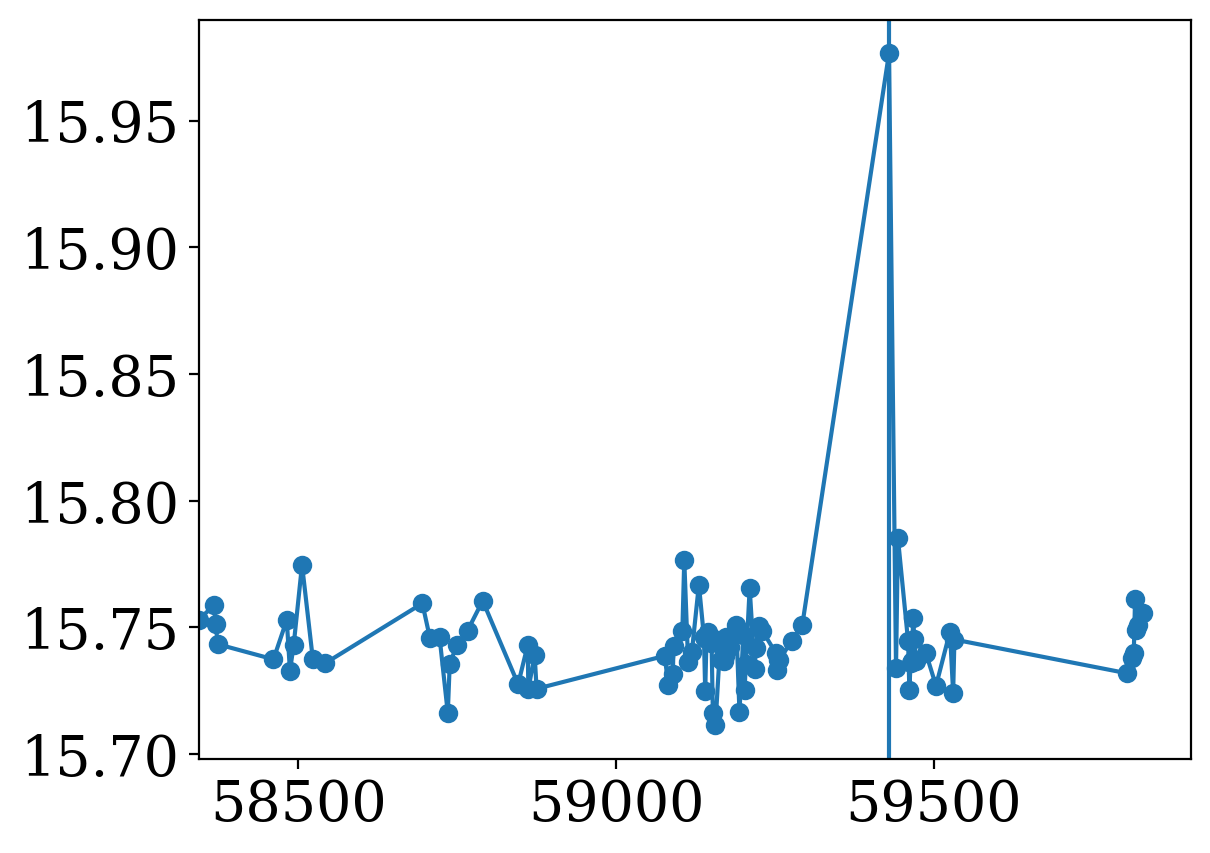

In [542]:
plt.plot(time, mag, 'o-')
plt.axvline(59429.47169)

plt.xlim(min(time))

In [550]:
def detect_bursts(time, flux, center_time, baseline_mean, baseline_std, burst_threshold=3.0, expansion_indices=1):
    """
    Detect bursts in a time series using linear interpolation.

    Parameters:
    - time: numpy array, time values of the light curve
    - flux: numpy array, flux values of the light curve
    - center_time: float, the center time of the burst
    - baseline_mean: float, expected baseline mean of the light curve
    - baseline_std: float, expected baseline standard deviation of the light curve
    - burst_threshold: float, higher threshold for burst detection
    - expansion_indices: int, number of indices to expand the burst region in each direction

    Returns:
    - burst_start: int, index of the start of the burst
    - burst_end: int, index of the end of the burst
    """

    # Define a linear interpolation function
    interpolate_flux = np.interp

    # Initialize burst_start and burst_end
    burst_start = burst_end = np.searchsorted(time, center_time)

    # Find burst start
    while burst_start > 0:
        burst_start -= 1
        if flux[burst_start] < baseline_mean + burst_threshold * baseline_std:
            break

    # Find burst end
    while burst_end < len(time) - 1:
        burst_end += 1
        if flux[burst_end] < baseline_mean + burst_threshold * baseline_std:
            break

    # Expand burst region towards the beginning
    burst_start = max(0, burst_start - expansion_indices)

    # Expand burst region towards the end
    burst_end = min(len(time) - 1, burst_end + expansion_indices)
    
    return time[burst_start], time[burst_end]


In [552]:
# Evaluate biweight location and scale
R, S = astro_stats.biweight.biweight_location(mag), astro_stats.biweight.biweight_scale(mag)

# Running deviation
running_deviation = dip_pipeline.deviation(mag, magerr, R, S)

In [555]:
detect_bursts(time, running_deviation, 59429.47169, np.mean(running_deviation), np.std(running_deviation), 
              expansion_indices=1)

(59276.13601, 59443.48533)

(59179.47169, 59444.47169)

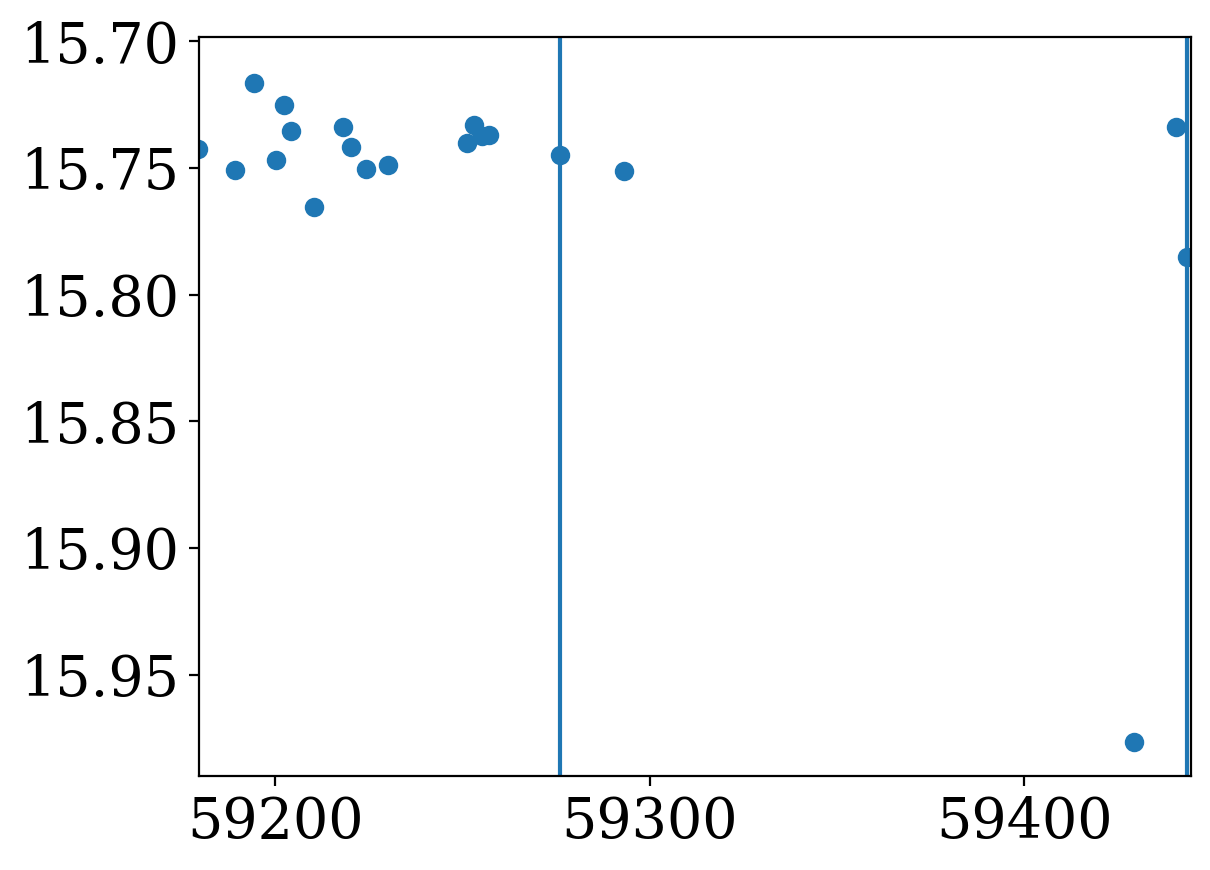

In [557]:
plt.scatter(time, mag)
for j in ([59276.13601, 59443.48533]):
    plt.axvline(j)
plt.ylim(plt.ylim()[::-1])
plt.xlim(59429.47169-250, 59429.47169+15)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 20.7 s, sys: 3.54 s, total: 24.3 s
Wall time: 22.8 s


(15.748524840176106, 14.981847856938838)

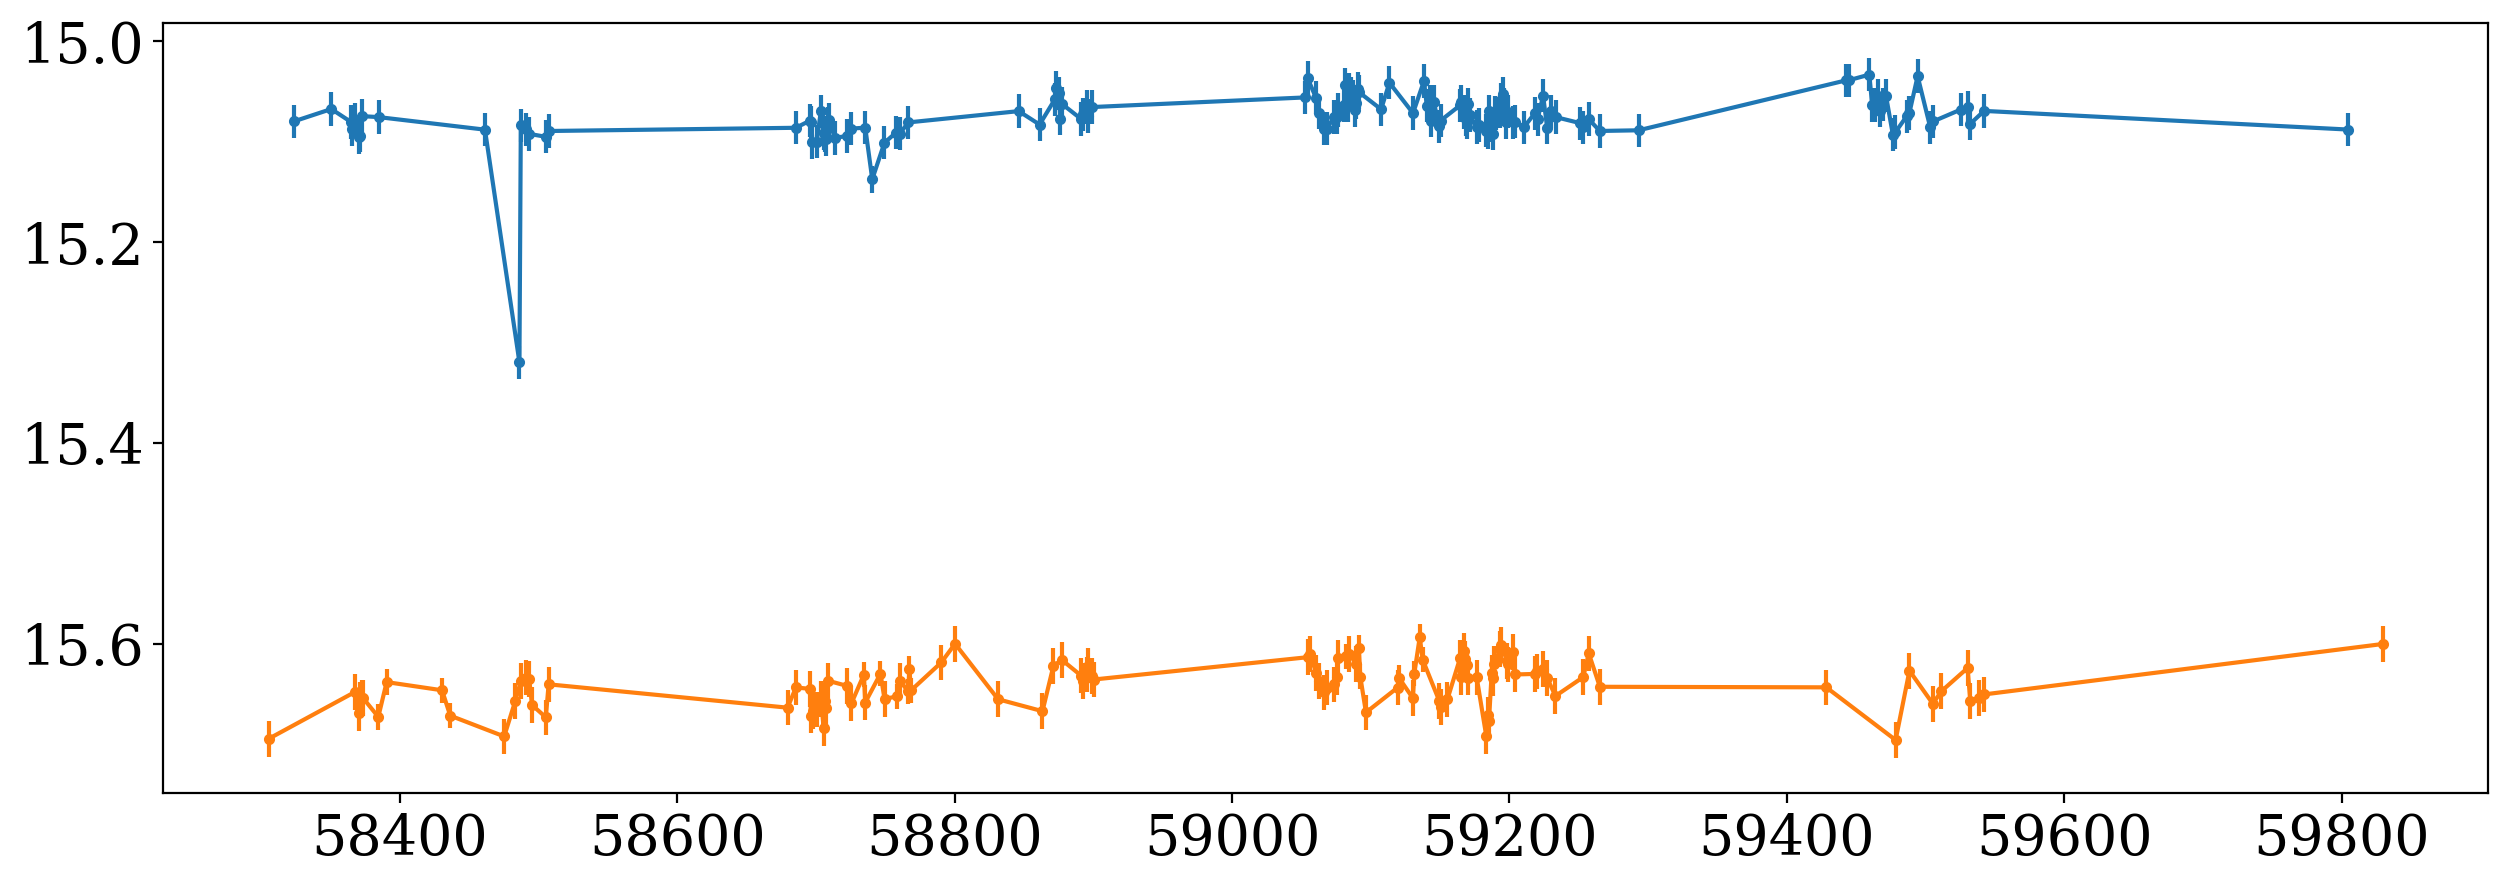

In [438]:
%%time
# know dipper
lc = ens.source.loc[9207088676864000]
lc = lc.compute()

time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

timeg, magg, magerrg = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='g', flag_good=0)


plt.figure(figsize=(15,5))
plt.errorbar(time, mag, magerr, fmt='.-')
plt.errorbar(timeg, magg, magerrg, fmt='.-')
plt.ylim(plt.ylim()[::-1])

In [439]:
lc

,ra_gaia_andy_fg_dwarfs,dec_gaia_andy_fg_dwarfs,parallax_gaia_andy_fg_dwarfs,parallax_over_error_gaia_andy_fg_dwarfs,bp_rp_gaia_andy_fg_dwarfs,solution_id_gaia_andy_fg_dwarfs,source_id_gaia_andy_fg_dwarfs,pmra_gaia_andy_fg_dwarfs,pmra_error_gaia_andy_fg_dwarfs,pmdec_gaia_andy_fg_dwarfs,...,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
9207088676864000,41.968257,3.146271,1.007373,33.049786,0.938857,1636148068921376768,4603522042077696,4.98723,0.033141,-12.312076,...,0,452,15.657446,0.017738,58503.16945,23,g,6,0,32
9207088676864000,41.968257,3.146271,1.007373,33.049786,0.938857,1636148068921376768,4603522042077696,4.98723,0.033141,-12.312076,...,0,452,15.650978,0.017737,58503.17036,23,g,6,0,32
9207088676864000,41.968257,3.146271,1.007373,33.049786,0.938857,1636148068921376768,4603522042077696,4.98723,0.033141,-12.312076,...,-32768,452,15.589905,0.017734,59082.45706,23,g,6,0,32
9207088676864000,41.968257,3.146271,1.007373,33.049786,0.938857,1636148068921376768,4603522042077696,4.98723,0.033141,-12.312076,...,0,452,15.673338,0.017741,58505.15119,23,g,6,0,32
9207088676864000,41.968257,3.146271,1.007373,33.049786,0.938857,1636148068921376768,4603522042077696,4.98723,0.033141,-12.312076,...,1,452,15.653457,0.017737,58490.12422,23,g,6,0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9207088676864000,41.968257,3.146271,1.007373,33.049786,0.938857,1636148068921376768,4603522042077696,4.98723,0.033141,-12.312076,...,0,452,15.071699,0.016650,59057.46293,23,r,6,0,32
9207088676864000,41.968257,3.146271,1.007373,33.049786,0.938857,1636148068921376768,4603522042077696,4.98723,0.033141,-12.312076,...,0,452,15.070017,0.016653,59185.17035,23,r,6,0,32
9207088676864000,41.968257,3.146271,1.007373,33.049786,0.938857,1636148068921376768,4603522042077696,4.98723,0.033141,-12.312076,...,0,452,15.090611,0.016622,59184.26007,23,r,6,0,32


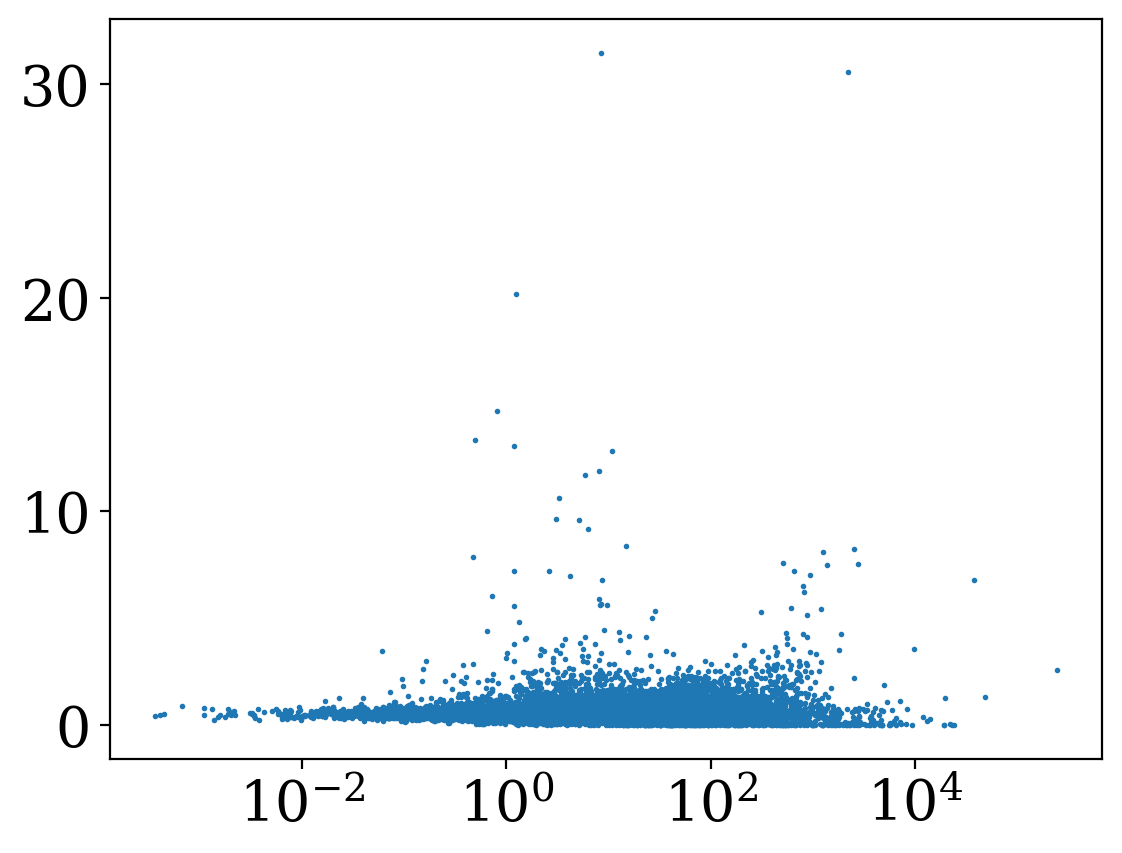

In [288]:
plt.scatter(demo_table['stetson_i'], demo_table['invNeumann'], s=1)

plt.xscale('log')
plt.yscale('log')

In [176]:
q = (demo_table['Nphot']>10) & (demo_table['invNeumann']>4) & (demo_table['Ndips']>0)

In [196]:
qq = (demo_table['Nphot']>50) 

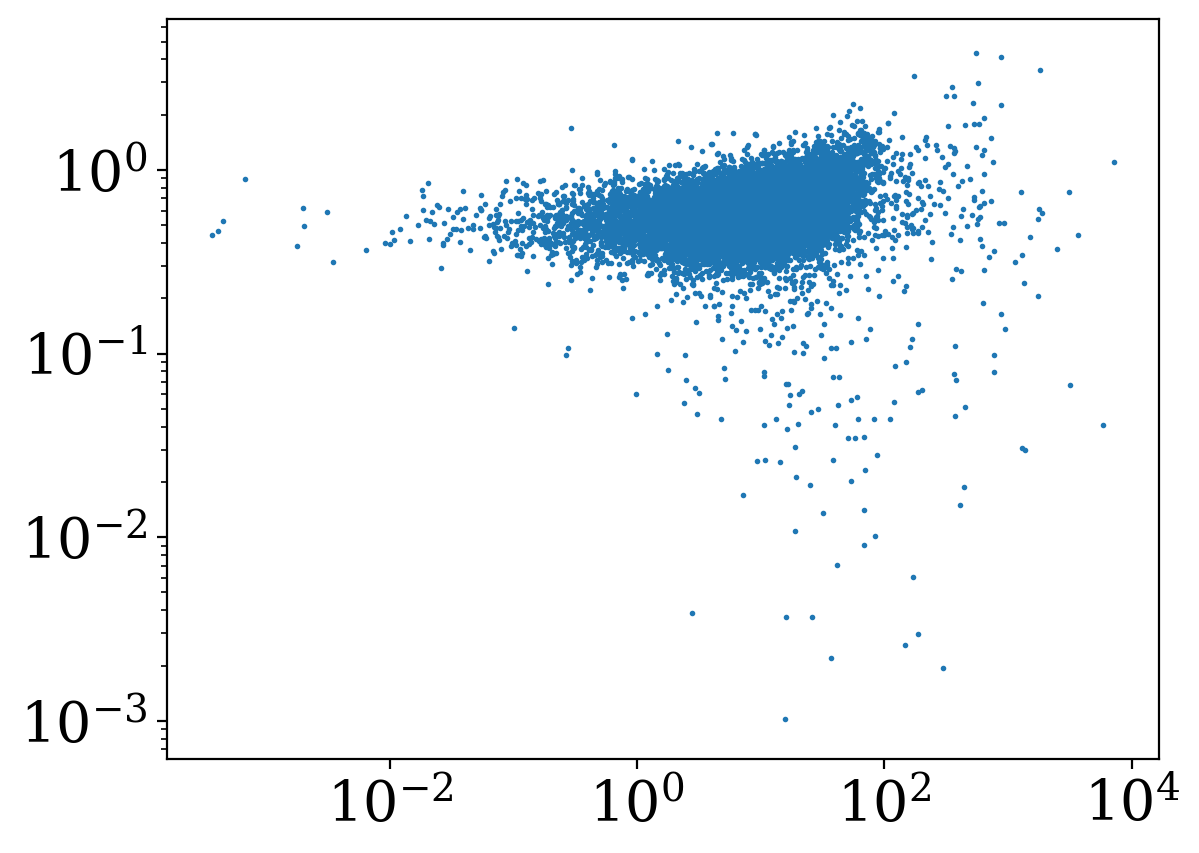

In [197]:
plt.scatter(demo_table['stetson_i'][qq], demo_table['invNeumann'][qq], s=1)

plt.xscale('log')
plt.yscale('log')

In [962]:
w = (demo_table['Ndips']>0) & (demo_table['best_dip_score']>50) & \
    (demo_table['closest_bright_star_arcsec']>0.001) & (demo_table['closest_bright_star_mag']>15) & \
    (demo_table['chi_square_gp']>0) & (demo_table['chi_square_gp']<150) & \
    (demo_table['best_dip_power']>7) & \
    (demo_table['best_dip_ndet']>0)

In [963]:
demo_table[w]

,ra_gaia,dec_gaia,parallax_gaia,parallax_over_error_gaia,bp_rp_gaia,solution_id_gaia,source_id_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,...,right_error,chi_square_gp,gp_fun,gp_status,separation_btw_peaks,closest_bright_star_arcsec,closest_bright_star_mag,closest_star_arcsec,closest_star_mag,density_arcsec2
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
64144503493099520,42.025266,14.109990,0.569902,12.622414,0.971536,1636148068921376768,32072243081883776,5.667276,0.052628,3.833100,...,0.007438,11.778459,1.0,0.073954,-0.002016,0.010227,15.429953,0.000020,15.788205,4581.829446
87851980893978624,55.007036,16.081296,0.595250,10.924937,1.105370,1636148068921376768,43925974863142912,4.872103,0.061618,-5.071064,...,0.003418,1.204415,1.0,0.224469,-0.669862,0.016148,15.810852,0.000009,16.229361,4581.829446
358668550329597952,65.388314,38.610963,1.094930,17.148130,1.773457,1636148068921376768,179334263500952448,4.097443,0.082996,-0.336843,...,0.013866,24.490351,1.0,4.814520,0.746873,0.009172,15.049505,0.000022,16.225807,24054.604591
366294310385090560,84.221346,35.698034,0.601723,11.461639,1.216539,1636148068921376768,183147133607168640,1.846448,0.057415,-2.871614,...,0.002717,48.451344,1.0,5.590187,-2.850311,0.012158,15.999073,0.000014,16.122231,41236.465014
369732514241052672,76.334988,34.146374,0.812877,15.059396,1.403766,1636148068921376768,184866254395965440,4.180284,0.063982,-3.645536,...,0.002558,3.579448,1.0,0.220115,-0.227512,0.015805,15.207442,0.000013,16.376425,34363.720845
384406850218491904,88.935109,42.004367,0.402521,6.890832,1.061482,1636148068921376768,192203398567036288,0.466664,0.054650,-5.272369,...,0.005805,60.678548,1.0,12.032120,1.864160,0.008956,15.851917,0.000040,16.345016,29781.891399
385553701986631680,86.577100,41.925838,0.345211,5.794281,1.181616,1636148068921376768,192776828239951872,-0.238674,0.070893,-0.059389,...,0.002679,149.694990,1.0,11.486158,48.563100,0.014876,15.324016,0.000018,16.510876,38945.550291
393498551386112000,89.886833,45.660381,0.491205,8.839048,0.933284,1636148068921376768,196749260671192192,0.059756,0.052970,-0.959378,...,0.003883,15.029822,1.0,0.087085,-0.356223,0.007670,15.354605,0.000035,16.111189,27490.976676
410914142736613376,74.965748,44.638249,0.983362,18.036420,1.523598,1636148068921376768,205457049167677184,4.102879,0.062988,-27.800307,...,0.006721,11.419360,1.0,0.917466,-0.421996,0.011498,15.857928,0.000003,16.182533,53836.495990


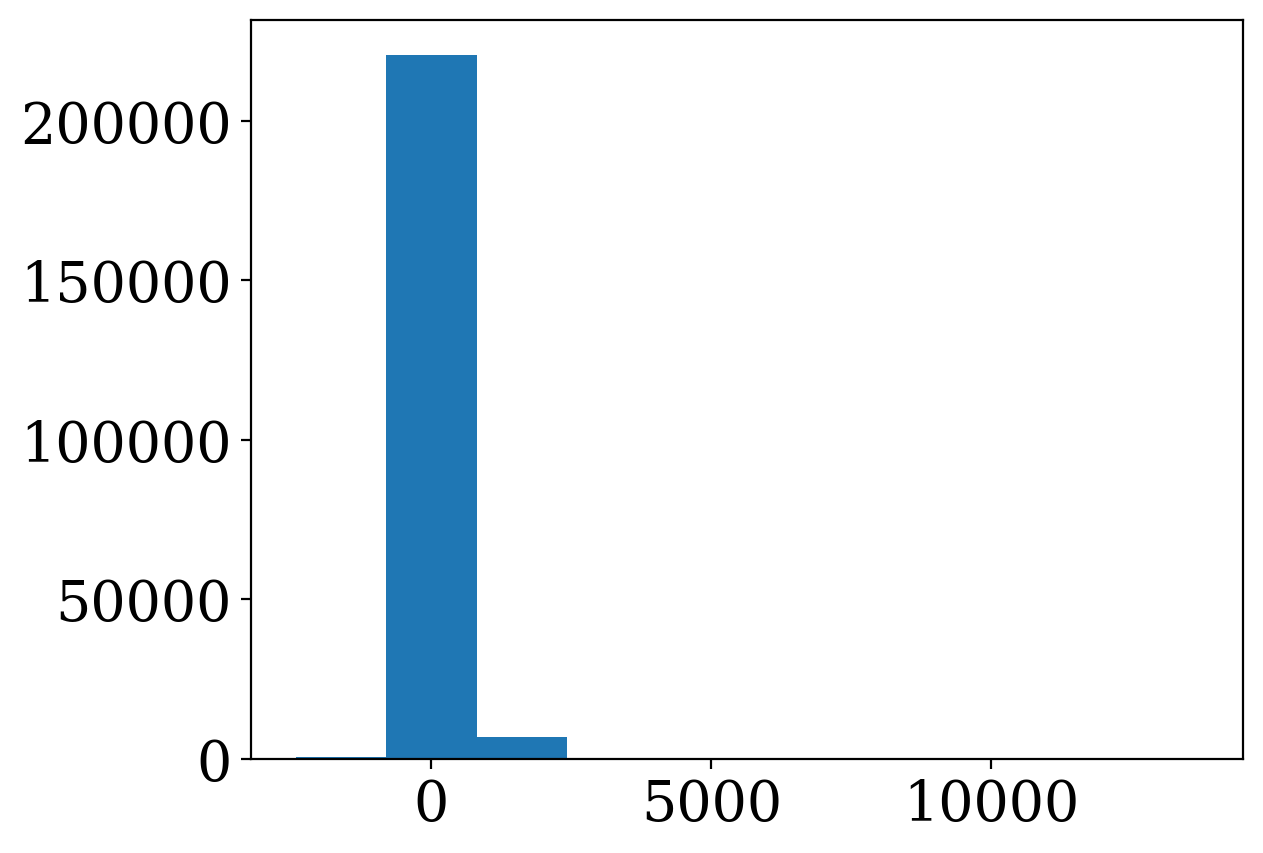

In [856]:
_ = plt.hist(demo_table['chi_square_gp'])

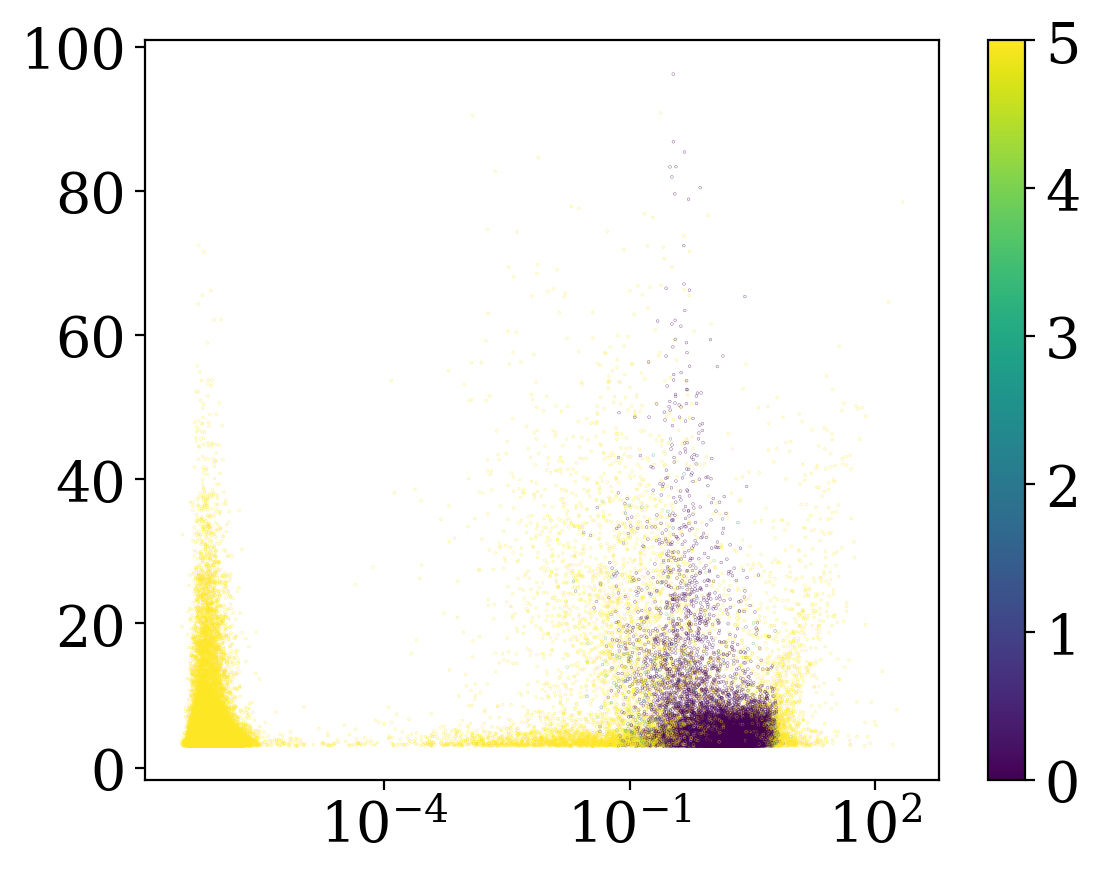

In [859]:
plt.scatter(demo_table['gp_status'], 
            demo_table['best_dip_power'], s=0.01, c=demo_table['chi_square_gp'], 
           vmin=0, vmax=5)
plt.colorbar()

plt.xscale('log')

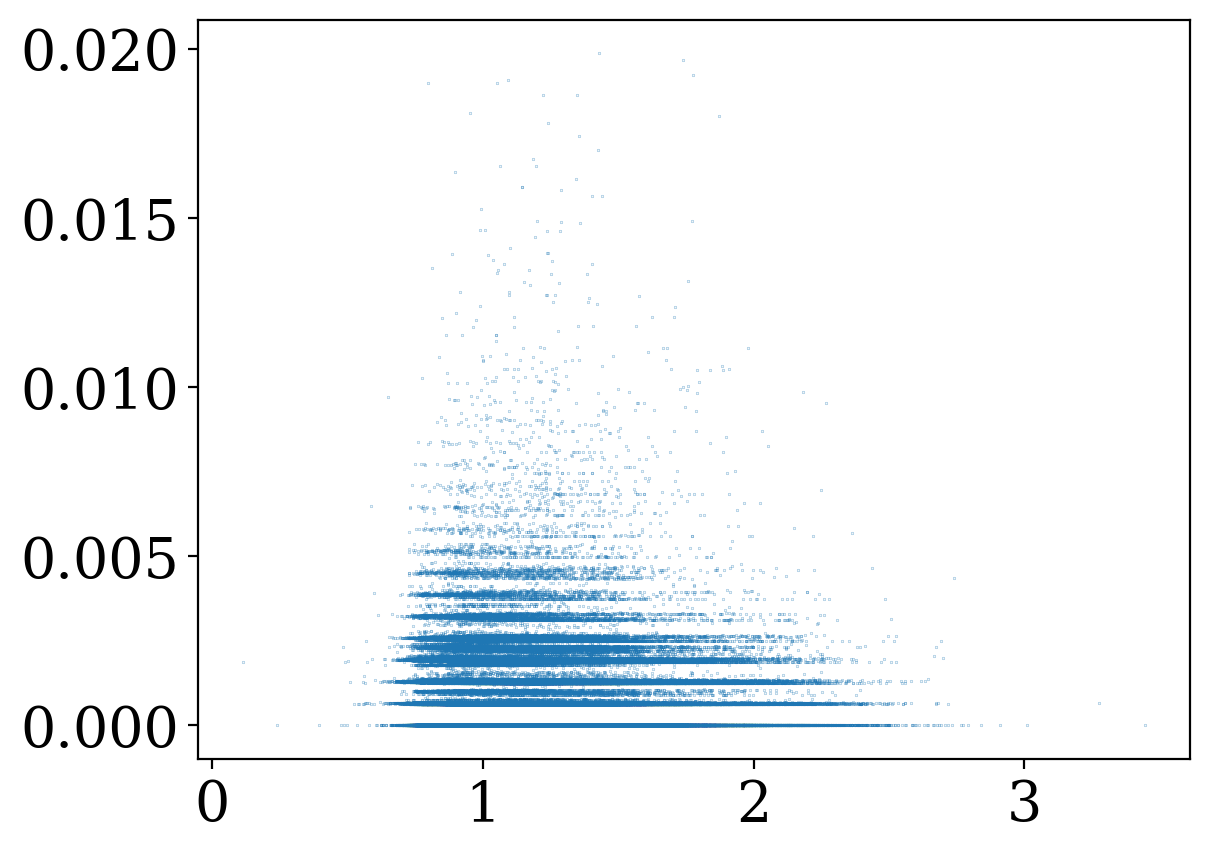

In [843]:
plt.scatter(demo_table['bp_rp_gaia'], 
            demo_table['rate'], s=0.01)

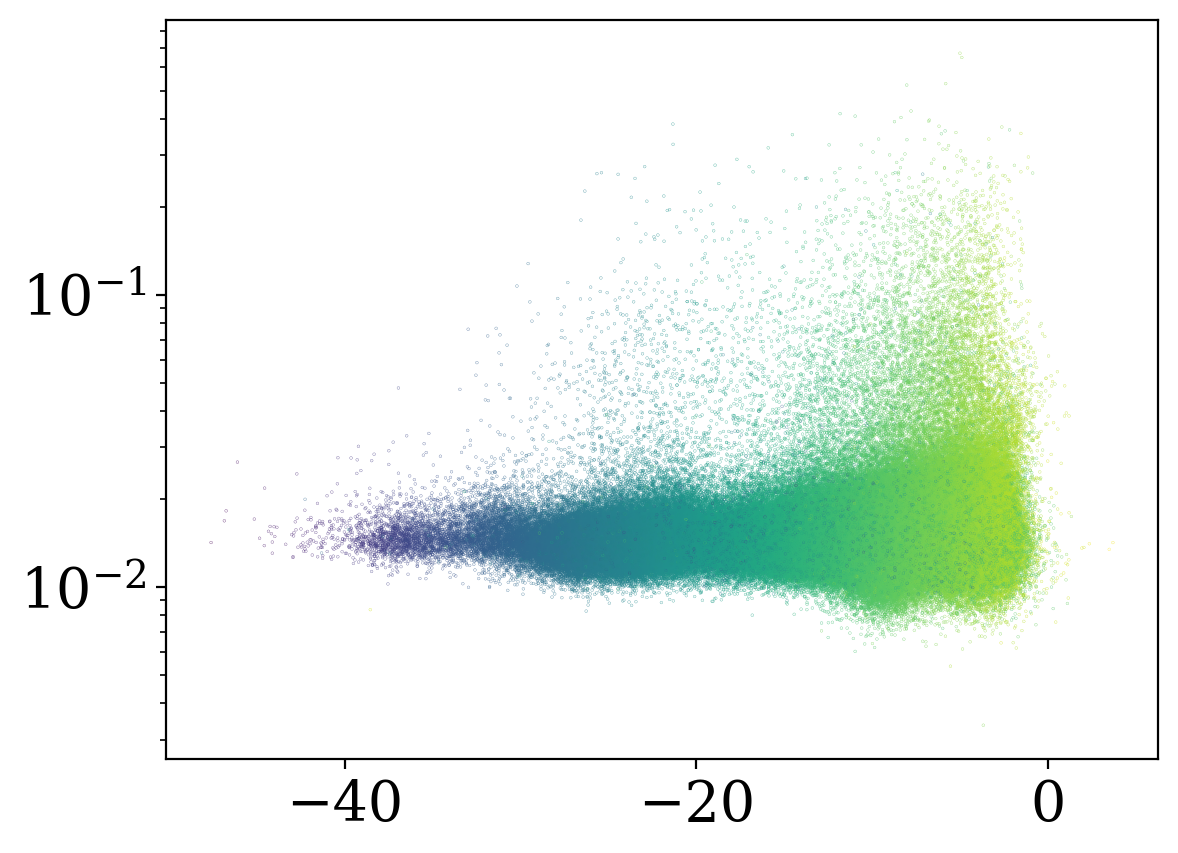

In [835]:
plt.scatter(demo_table['ADF_const'], 
            demo_table['biweight_scale'],
            s=0.01, c=demo_table['ADF_const_trend'])
plt.yscale('log')

In [ ]:
%%time
full_table = ens.object.head(4_833_834, npartitions=287_241)
# ran at 12:04am jan 9

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 2.57 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [811]:
full_table

NameError: name 'full_table' is not defined

In [860]:
%%time
lc = ens.source.loc[501473206847143936]

CPU times: user 161 ms, sys: 144 ms, total: 305 ms
Wall time: 285 ms


In [862]:
%%time
lc = lc.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


KeyboardInterrupt: 

## Source Examination

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


KeyboardInterrupt: 

(16.369356907904148, 16.166746828705072)

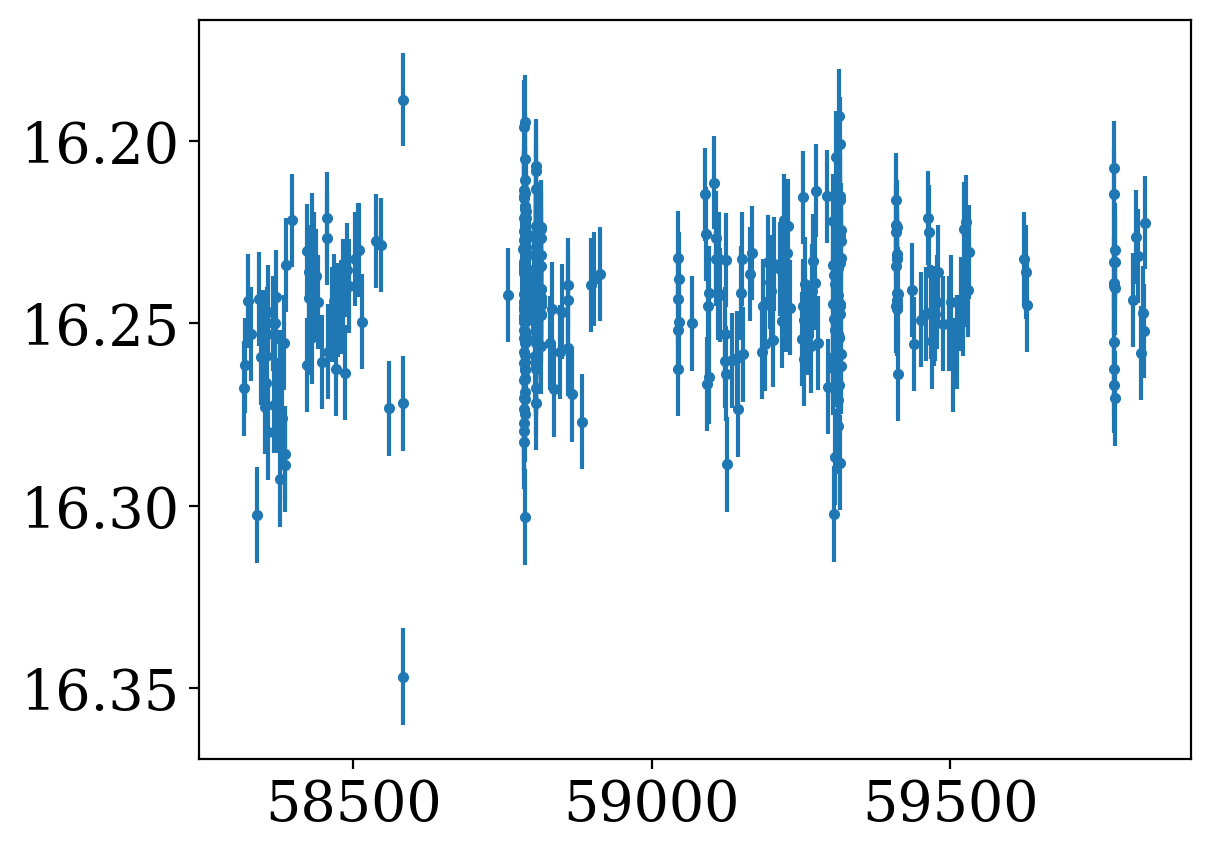

In [827]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], band_of_study='r', flag_good=0)

plt.errorbar(time, mag, magerr, fmt='.')
plt.ylim(plt.ylim()[::-1])


(16.369356907904148, 16.166746828705072)

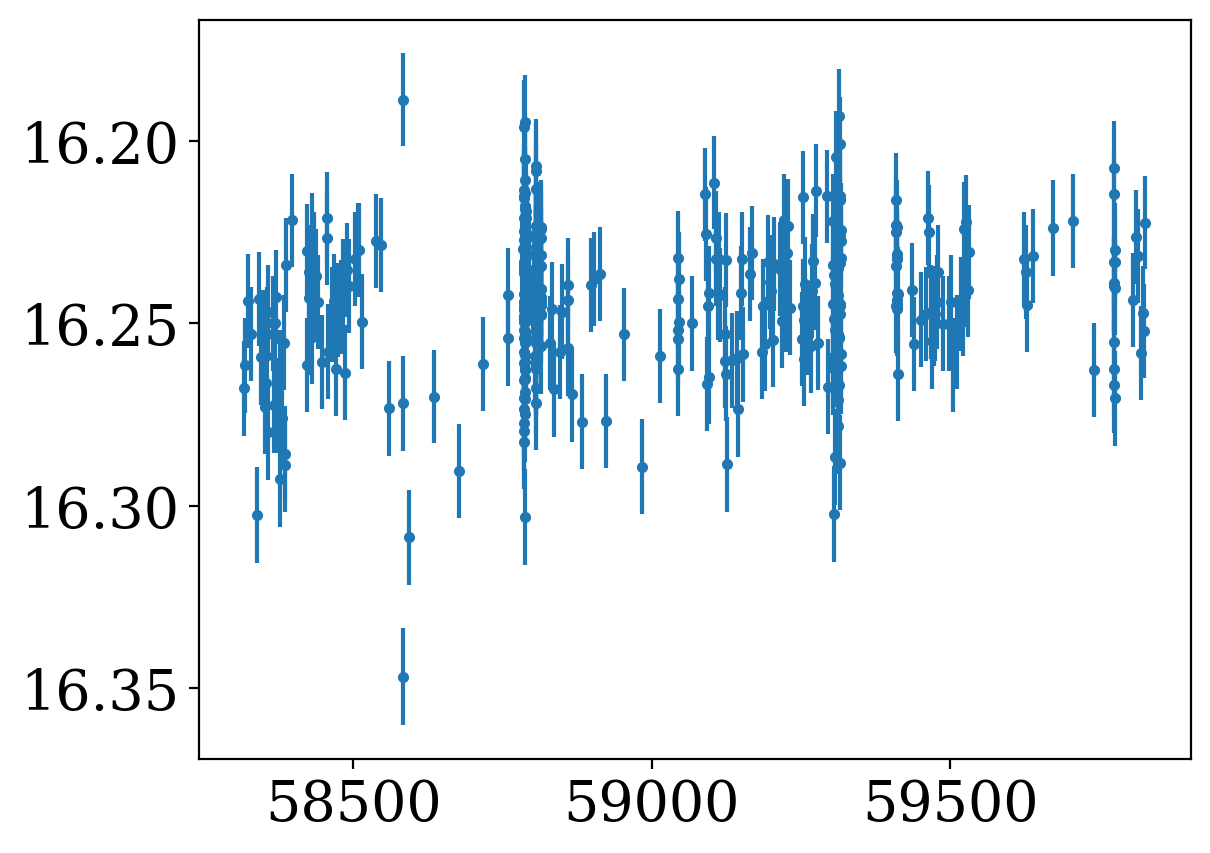

In [828]:
time, mag, magerr = my_tools.fill_gaps(time, mag, magerr, num_points=5, max_gap_days=95, window_size=0)
plt.errorbar(time, mag, magerr, fmt='.')
plt.ylim(plt.ylim()[::-1])


In [564]:
# Evaluate biweight location and scale
R, S = astro_stats.biweight.biweight_location(mag), astro_stats.biweight.biweight_scale(mag)

# Running deviation
running_deviation = dip_pipeline.deviation(mag, magerr, R, S)

In [565]:
# Peak detection summary per light curve
peak_detections = dip_pipeline.peak_detector(time, running_deviation, power_thresh=5,  peak_close_rmv=15, pk_2_pk_cut=250)

# Select best peak candidate with at least 3 points in the dip
bp = dip_pipeline.best_peak_detector(peak_detections, min_in_dip=5)

No dip is found within the minimum number of detections.


In [965]:
%%time
lc = lc.compute()


KeyboardInterrupt



In [10]:
import pandas as pd

In [140]:
len(pd.read_csv("temp/alias_dips.csv"))

FileNotFoundError: [Errno 2] No such file or directory: 'temp/alias_dips.csv'

In [139]:
!rm -rf temp/alias_dips.csv

In [108]:
!ls temp/

alias_dips.csv


In [88]:
!ls temp/

alias_dips.csv
